In [5]:
import torch
from tqdm import tqdm
import sys
sys.path.insert(0, '../')
sys.path.insert(0, '../GGH')

from GGH.data_ops import DataOperator
from GGH.selection_algorithms import AlgoModulators
from GGH.models import initialize_model, Autoencoder
from GGH.train_val_loop import TrainValidationManager
from GGH.inspector import Inspector, plot_histogram, visualize_train_val_error, selection_histograms, create_heatmap, cluster_and_visualize, \
                            get_gradarrays_n_labels, prep_tsne_min_max_ranges, sep_grads_by_labels, reset_pt_files, clean_final_analysis
from GGH.imputation_methods import Imputer
import warnings
warnings.filterwarnings('ignore')

def full_experiment(use_info, DO, INSPECT, batch_size, hidden_size, output_size, num_epochs, rand_state, results_path, dropout = 0.05, lr = 0.004,
                    nu = 0.1, normalize_grads_contx = False, use_context = True, final_analysis = True):
       
    AM = AlgoModulators(DO, lr = lr, nu = nu)
    dataloader = DO.prep_dataloader(use_info, batch_size)

    model = initialize_model(DO, dataloader, hidden_size, rand_state, dropout = dropout) 

    TVM = TrainValidationManager(use_info, num_epochs, dataloader, batch_size, rand_state, results_path, final_analysis = final_analysis)
    TVM.train_model(DO, AM, model, final_analysis = final_analysis)

    INSPECT.save_train_val_logs(DO, AM, TVM, model, final_analysis = final_analysis)
    
    return DO, TVM, model

def multi_experiments(total_runs, use_info, num_epochs, data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc,
                      INSPECT, batch_size, hidden_size, output_size, results_path, hyperparameters, final_analysis = True):
    
    progress_bar = tqdm(total=total_runs)
    for r_state in range(2000): #
        set_to_deterministic(r_state)
        DO = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc, r_state, device = "cpu") #cuda
        if not DO.lack_partial_coverage:
            full_experiment(use_info, DO, INSPECT, batch_size, hidden_size, output_size, num_epochs, r_state, results_path,
                            hyperparameters["dropout"]["value"], hyperparameters["lr"]["value"], hyperparameters["nu"]["value"],
                            hyperparameters["normalize_grads_contx"]["value"], hyperparameters["use_context"]["value"], final_analysis)
            progress_bar.update(1)
        if progress_bar.n == total_runs:
            break       
    progress_bar.close()

import sys
import io
import contextlib
def allowed_print(*args, **kwargs):
    """Print immediately to the notebook output even when stdout is redirected."""
    print(*args, **kwargs, file=_real_stdout)

In [6]:
#User requiered data and parameters
data_path = '../data/dataset_photo_pce10/data.csv'
results_path = "../saved_results/Photocell Degradation"
inpt_vars = ['P3HT', 'PTB7-Th']
target_vars = ['Degradation']
miss_vars = ['PCBM']
hypothesis = [[0.03, 0.11, 0.20, 0.32, 0.43, 0.6]]

#Percentage of simulated data with full information
partial_perc = 0.015 #0.03 #0.02 #0.015 
rand_state = 42

#Model Train Parameters
hidden_size = 32

batch_size = 100*len(hypothesis[0])
output_size = len(target_vars)

#Call data, algorithm and model classes
INSPECT = Inspector(results_path, hidden_size)

100%|██████████| 100/100 [07:16<00:00,  4.37s/it]


0.4428953176622412
0.44210854918567044


findfont: Font family ['Cambria'] not found. Falling back to DejaVu Sans.


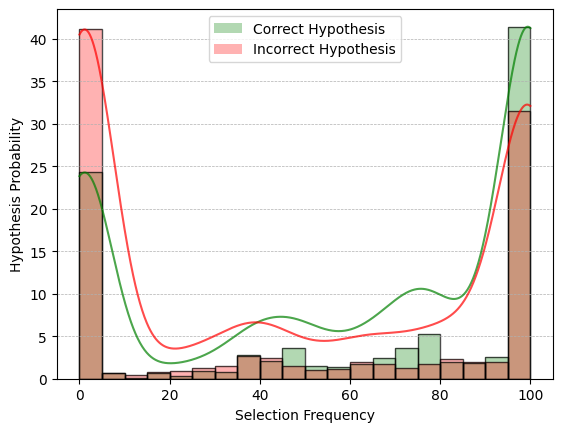

In [3]:
partial_perc = 0.03
rand_state = 42

use_info = "use hypothesis"
num_epochs = 100
DO = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc, rand_state, device = "cpu")
DO, TVM, model = full_experiment(use_info, DO, INSPECT, batch_size, hidden_size, output_size, num_epochs, rand_state, 
                                 results_path, dropout = 0.05, nu = 0.1, final_analysis = False)

print(INSPECT.calculate_val_r2score(DO, TVM, model, data = "validation"))
print(INSPECT.calculate_val_r2score(DO, TVM, model, data = "test"))

selection_histograms(DO, TVM, num_epochs, rand_state, partial_perc)

In [7]:
#%%capture

#Number of loops to ensure statistical significance
num_loops = 15
num_epochs = 240

hyperparameters = {"lr": {"value": 0.004}, "dropout": {"value": 0.05}, "nu": {"value": 0.1} ,
                   "normalize_grads_contx": {"value":False}, "use_context": {"value":True}}

#Clean dir
reset_pt_files(results_path)

#multi_experiments(num_loops, "use hypothesis", num_epochs, data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc, 
#                  INSPECT, batch_size, hidden_size, output_size, results_path, hyperparameters)
multi_experiments(num_loops, "partial info",   int(num_epochs*2.5), data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc, 
                  INSPECT, batch_size, hidden_size, output_size, results_path, hyperparameters)
multi_experiments(num_loops, "use known only", int(num_epochs*2.5), data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc,
                  INSPECT, batch_size, hidden_size, output_size, results_path, hyperparameters)
multi_experiments(num_loops, "full info",      int(num_epochs*2.5), data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc,
                  INSPECT, batch_size, hidden_size, output_size, results_path, hyperparameters)

Total .pt files deleted: 21



100%|██████████| 15/15 [00:15<00:00,  1.03s/it]

100%|██████████| 15/15 [01:08<00:00,  4.58s/it]

100%|██████████| 15/15 [01:09<00:00,  4.60s/it]


In [9]:
%%capture

buf = io.StringIO()
_real_stdout = sys.stdout
with contextlib.redirect_stdout(buf):
    for imput_method in ["Iterative MICE Imputer", "KNN Imputer", "Miss Forest", "Deep Regressor", "Soft Impute", 
                         "Matrix Factorization", "Hyperimpute", "TabPFN"]: #, "Midas"
        allowed_print(f"Executing benchmark for {imput_method}...")
        counter = 0
        use_info = "use imputation"
        num_epochs = 500
        for r_state in range(300):
            DO = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc, r_state, device = "cpu")
            if not DO.lack_partial_coverage:
                counter += 1
                AM = AlgoModulators(DO, lr = 0.004)
                IMP = Imputer(DO)
                dataloader = IMP.impute_w_sel(DO, imput_method, batch_size)

                model = initialize_model(DO, dataloader, hidden_size, r_state, dropout = 0.05) 
                TVM = TrainValidationManager(use_info, num_epochs, dataloader, batch_size, r_state, results_path,
                                            imput_method = imput_method, final_analysis = True)
                TVM.train_model(DO, AM, model)
                INSPECT.save_train_val_logs(DO, AM, TVM, model, imput_method, final_analysis = True)
            if counter == 15:
                break

In [11]:
#3% partial
INSPECT.create_comparison_table(final_analysis = True, use_info= "use imputation")

,Method,valid_min_errors_mean,valid_min_errors_std
0,Matrix Factorization,0.008590,0.001167
1,Iterative MICE Imputer,0.009385,0.001354
2,KNN Imputer,0.008594,0.001541
3,Miss Forest,0.008927,0.001303
4,Deep Regressor,0.009360,0.001340
5,Soft Impute,0.009430,0.001182
6,Hyperimpute,0.009064,0.001461
7,TabPFN,0.008891,0.001934


In [10]:
#3% partial
df, df_notavg = INSPECT.create_test_comparison_table(data_path, inpt_vars, target_vars, miss_vars, hypothesis, 
                                                     partial_perc, batch_size, best_imput = "TabPFN")

df[["Method", "avg_r2_score", "avg_mse", "avg_mae"]]

,Method,avg_r2_score,avg_mse,avg_mae
0,full info,0.846324,0.001810,0.027383
1,partial info,0.349678,0.007936,0.061570
2,use hypothesis,0.399229,0.007323,0.061611
3,use imputation,0.132481,0.011659,0.079073
4,use known only,0.114149,0.010582,0.074476


In [12]:
#3% partial
df, df_notavg = INSPECT.create_test_comparison_table(data_path, inpt_vars, target_vars, miss_vars, hypothesis, 
                                                     partial_perc, batch_size, best_imput = "Matrix Factorization")

df[["Method", "avg_r2_score", "avg_mse", "avg_mae"]]

,Method,avg_r2_score,avg_mse,avg_mae
0,full info,0.846324,0.001810,0.027383
1,partial info,0.349678,0.007936,0.061570
2,use hypothesis,0.399229,0.007323,0.061611
3,use imputation,0.164737,0.009950,0.073046
4,use known only,0.114149,0.010582,0.074476


In [10]:
#2% partial
INSPECT.create_comparison_table(final_analysis = True, use_info= "use imputation")

,Method,valid_min_errors_mean,valid_min_errors_std
0,Matrix Factorization,0.008660,0.001147
1,Iterative MICE Imputer,0.009515,0.001460
2,KNN Imputer,0.008944,0.001511
3,Miss Forest,0.009149,0.001408
4,Deep Regressor,0.009465,0.001293
5,Soft Impute,0.009493,0.001180
6,Hyperimpute,0.009258,0.001531
7,TabPFN,0.008884,0.002077


In [11]:
#2% partial
df, df_notavg = INSPECT.create_test_comparison_table(data_path, inpt_vars, target_vars, miss_vars, hypothesis, 
                                                     partial_perc, batch_size, best_imput = "Matrix Factorization")

df[["Method", "avg_r2_score", "avg_mse", "avg_mae"]]

,Method,avg_r2_score,avg_mse,avg_mae
0,full info,0.849640,0.001798,0.027267
1,partial info,0.314744,0.008560,0.066124
2,use hypothesis,0.382335,0.007702,0.063554
3,use imputation,0.152704,0.010305,0.075454
4,use known only,0.117343,0.010759,0.075293


In [8]:
df, df_notavg = INSPECT.create_test_comparison_table(data_path, inpt_vars, target_vars, miss_vars, hypothesis, 
                                                     partial_perc, batch_size, best_imput = "Midas")

df.dropna(inplace = True)
df[["Method","avg_r2_score","avg_mse","avg_mae"]]

,Method,avg_r2_score,avg_mse,avg_mae
0,full info,0.872567,0.001618,0.027446
1,partial info,0.144527,0.011001,0.077040
3,use known only,0.138952,0.011055,0.077336


In [6]:
df, df_notavg = INSPECT.create_test_comparison_table(data_path, inpt_vars, target_vars, miss_vars, hypothesis, 
                                                     partial_perc, batch_size, best_imput = "Midas")

df.dropna(inplace = True)
df[["Method","avg_r2_score","avg_mse","avg_mae"]]

,Method,avg_r2_score,avg_mse,avg_mae
0,use hypothesis,0.325064,0.008740,0.068323
1,use known only,0.143105,0.011313,0.077256
2,partial info,0.137756,0.011097,0.078377
3,full info,0.879808,0.001529,0.026339
4,use imputation,0.178574,0.010541,0.075807
